# My First Intraday Trading Strategy

This notebook is part of my learning journey.  
I want to practice using **Git, GitHub, and Python** while also testing my **first intraday trading strategy**.  

The strategy I chose is called an **Opening Range Breakout (ORB)**.  
The idea: look at the first few minutes after the market opens, define a price range, and trade depending on whether the price breaks above or below that range.

In [25]:
import yfinance as yf
import datetime as dt
from backtesting import Strategy, Backtest

## Step 1: Collect Intraday Data

To test the strategy, I will download **1-minute intraday stock data** from Yahoo Finance using the `yfinance` library.  

I will use Apple (AAPL) as my test case, but later I could try other tickers too.

In [26]:
df = yf.download(
    tickers="AAPL",
    interval="1m",
    period='8d'
)

/var/folders/r6/jv1hv35d4rg8crmf3xb99ykc0000gn/T/ipykernel_19910/200115773.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


## Step 2: Preprocess the Data

`yfinance` gives the data with a MultiIndex (e.g. first level = `Price, Close, High...`, second level = ticker name).  
For backtesting, I only need flat column names.  

I drop the `"Ticker"` level so the DataFrame has simple columns: `Open, High, Low, Close, Volume`.

In [27]:
df = df.droplevel("Ticker", axis=1)

## Step 3: Define the Opening Range Breakout Strategy

The rules I will use for my **first intraday strategy**:

1. Take the first 5 minutes after the market opens (the "opening range").
2. Record the highest and lowest price during this range.
3. If the price is above the day's open after the range ends → go **long**.
4. If the price is below the day's open after the range ends → go **short**.
5. Use risk management:
   - Risk per trade = 1% of equity
   - Stop loss = the opposite side of the opening range
   - Take profit = 10 × the risk distance
6. Close all positions before market close.

This is a **simple starting point** - the main goal is to learn how to build and backtest an intraday strategy.

In [28]:
class OpeningRangeBreakout(Strategy):
    # Strategy parameters
    open_range_minutes = 5
    last_minute_bar_in_opening_range = dt.time(13, 30 + open_range_minutes)
    exit_minute_bar = dt.time(19, 58)
    risk_percent = 0.01  # 1% of equity
    take_profit_multiplier = 10  # Take profit at 10x the risk
    max_leverage = 4  # 4x leverage
    
    # what we want to initialize in the berginning
    def init(self):
        self.current_day        = None # tracks current day
        self.current_day_open   = None
        self.opening_range_high = None # tracks high of opening range
        self.opening_range_low  = None # tracks low of opening range
        
    # every day is going to have a different opening range high and low
    def _reset_range(self, day, open):
        self.current_day        = day
        self.current_day_open   = open
        self.opening_range_high = None
        self.opening_range_low  = None
        
    def _get_position_size(self, entry_price: float, stop_price: float) -> int:
        per_share_risk = abs(entry_price - stop_price) 

        if per_share_risk == 0:
            return 0

        # Risk-based cap: position that loses 1 % of equity at the stop
        shares_by_risk = (self.risk_percent * self.equity) / per_share_risk

        # Leverage-based cap: shares affordable with 4× buying power
        shares_by_leverage = (self.max_leverage * self.equity) / entry_price

        # Final size: smaller of the two, floored to an int
        return int(min(shares_by_risk, shares_by_leverage))
        
    # function that is called on every new bar
    def next(self):
        # get current time and date
        t = self.data.index[-1]
        current_bar_date = t.date()

        # if new day, reset opening range
        if self.current_day != current_bar_date:
            self._reset_range(current_bar_date, self.data.Open[-1])
            print(t.time())
        
        # if we are still in the opening range period, update high and low
        if t.time() <= self.last_minute_bar_in_opening_range:
            if self.opening_range_high is None:
                self.opening_range_high = self.data.High[-1]
                self.opening_range_low  = self.data.Low[-1]
            else:
                self.opening_range_high = max(self.opening_range_high, self.data.High[-1])
                self.opening_range_low  = min(self.opening_range_low,  self.data.Low[-1])
                
        # right when the opening range closes, decide to go long or short
        if t.time() == self.last_minute_bar_in_opening_range:
          print(f"opening range high is {self.opening_range_high}")
          print(f"opening range low is {self.opening_range_low}")
        
          # only take a position if we are not already in one
          if not self.position:
            # Calculate range size and planned entry price
            range_size = self.opening_range_high - self.opening_range_low
            planned_entry_price = self.data.Close[-1]  # Using current close as entry price
        
            if self.data.Close[-1] > self.current_day_open:
              # Calculate position size based on risk management
              stop_loss_price = self.opening_range_low
              position_size = self._get_position_size(planned_entry_price, stop_loss_price)
              take_profit_price = planned_entry_price + (self.take_profit_multiplier * range_size)
              
              print(f"going long, position size {position_size} at planned price {planned_entry_price}, stop loss {stop_loss_price}")
              self.buy(size=position_size, sl=stop_loss_price, tp=take_profit_price)
              
            elif self.data.Close[-1] < self.current_day_open:
              # Calculate position size based on risk management
              stop_loss_price = self.opening_range_high
              position_size = self._get_position_size(planned_entry_price, stop_loss_price)
              take_profit_price = planned_entry_price - (self.take_profit_multiplier * range_size)
              
              print(f"going short, position size {position_size} shares at planned price {planned_entry_price}, stop loss {stop_loss_price}")
              self.sell(size=position_size, sl=stop_loss_price, tp=take_profit_price)
              
            else:
              print("doing nothing")

        if self.position and t.time() == self.exit_minute_bar:
          print("closing out position")
          self.position.close()        

In [29]:
def per_share_commission(size, price):
    return abs(size) * 0.0005

## Step 4: Backtest the Strategy

I will run the backtest using the `backtesting.py` library.  

Since this is my **first intraday strategy**, the results are less important than the process. The goal is to **learn how everything fits together**.

In [30]:
bt = Backtest(df, OpeningRangeBreakout, cash=25000, 
              commission=per_share_commission, margin=0.25)

stats = bt.run()

from bokeh.io import output_notebook
output_notebook()
bt.plot()
print(stats)

13:31:00
opening range high is 231.58999633789062
opening range low is 230.2100067138672
going short, position size 257 shares at planned price 230.6199951171875, stop loss 231.58999633789062
closing out position
13:30:00
opening range high is 227.77000427246094
opening range low is 226.64999389648438
going long, position size 273 at planned price 227.60000610351562, stop loss 226.64999389648438
closing out position
13:30:00
opening range high is 230.94000244140625
opening range low is 229.9199981689453
going long, position size 463 at planned price 230.22000122070312, stop loss 229.9199981689453
13:30:00
opening range high is 238.02000427246094
opening range low is 236.77999877929688
going long, position size 400 at planned price 237.44290161132812, stop loss 236.77999877929688
13:30:00
opening range high is 237.38999938964844
opening range low is 236.69000244140625
going long, position size 443 at planned price 237.10000610351562, stop loss 236.69000244140625
13:30:00
opening range h

Loading BokehJS ...

/Users/melkerliljegren/Documents/Python Repositories/Projects/Intraday_Strategy/.venv/lib/python3.12/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


Start                     2025-09-10 13:30...
End                       2025-09-19 19:59...
Duration                      9 days 06:29:00
Exposure Time [%]                    46.34146
Equity Final [$]                   25756.2701
Equity Peak [$]                   26854.16114
Commissions [$]                         2.535
Return [%]                            3.02508
Buy & Hold Return [%]                 6.07593
Return (Ann.) [%]                   -21.21019
Volatility (Ann.) [%]                18.28023
CAGR [%]                            124.82378
Sharpe Ratio                         -1.16028
Sortino Ratio                        -1.82869
Calmar Ratio                         -5.18796
Alpha [%]                             3.36151
Beta                                 -0.05537
Max. Drawdown [%]                    -4.08835
Avg. Drawdown [%]                    -0.47857
Max. Drawdown Duration        4 days 06:21:00
Avg. Drawdown Duration        0 days 05:42:00
# Trades                          

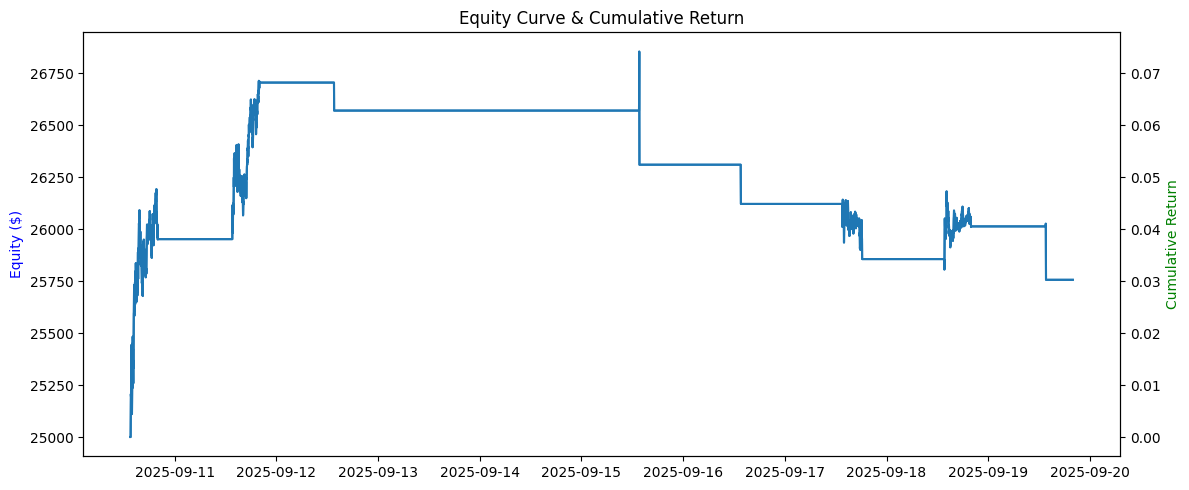

In [41]:
import matplotlib.pyplot as plt

equity = stats['_equity_curve']['Equity']
cum_return = (1 + equity.pct_change().fillna(0)).cumprod() - 1

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(equity, label="Equity")
ax1.set_ylabel("Equity ($)", color="b")

ax2 = ax1.twinx()
ax2.plot(cum_return, label="Cumulative Return")
ax2.set_ylabel("Cumulative Return", color="g")

plt.title("Equity Curve & Cumulative Return")
fig.tight_layout()
plt.savefig("assets/equity_with_return.png", dpi=150)
plt.show()
